In [1]:
import os
from pylab import *
from pysb.core import *
from pysb.bng import *
from pysb.integrate import *
import matplotlib.pyplot as plt
import numpy as np
from pysb.util import alias_model_components
from pysb.simulator import CupSodaSimulator
from pysb.simulator import ScipyOdeSimulator
from pysb.simulator.bng import BngSimulator
import sys
sys.path.append('../')
sys.path.append('/home/ildefog/main/Projects/NERM/')
sys.path.append('/home/ildefog/main/Projects/NERM/param_files/')
from model_files.nerm_pvals import model 
import pandas as pd
from scipy import stats
from pysb.simulator import SimulationResult
import logging
import os
from pysb.logging import setup_logger
from pysb.simulator.cupsoda import CupSodaSimulator
from pysb.simulator.scipyode import ScipyOdeSimulator
from sensitivity_analysis4 import InitialsSensitivity
from pysb.util import update_param_vals
from scipy.stats import norm,uniform, halfnorm
from pysb.tools.sensitivity_analysis import PairwiseSensitivity
os.environ['OMP_NUM_THREADS'] = '1'
from scipy.optimize import curve_fit

In [17]:
k6 = np.array([9000.,  3799.,  9000.,  9000.,  3109.,  3900.,  7226.,  5544.,
       40000., 10654.,  2326.,  4800.,  4696., 11776.,
               2.27936332e-07, 2.03192302e-05, 8.42787652e-03, 1.01281294e-03,
       2.25992087e+01, 1.86689498e+01, 2.35337020e+00, 3.14177062e+01,
       4.68168588e-08, 2.13436640e-05, 9.12557805e-03, 1.59053561e-04,
       5.10968318e-05, 4.36373852e-08, 1.68304286e+01, 1.38112636e-02,
       2.43448138e-04, 1.68304286e+01, 6.58856473e-03, 9.85771644e+03,
       2.74001544e+02, 4.04560795e+01, 1.80311731e+01, 2.70361886e-02,
       3.66802221e+00, 3.55326650e-07, 1.63819971e-02, 1.18105290e+01,
       1.74349666e+01, 1.33345991e-03, 2.93549260e-03, 6.16725475e-03,
       5.14627335e+01, 7.12591081e-02, 3.56335057e-04, 1.71749193e-03,
       4.40157675e-04, 9.16486135e-01, 4.92272994e-01, 4.34042153e+03])

In [ ]:
mode4_100 = np.load('../../param_files/necro_pars10k_cluster3_5720_mod.npy')[:,14:]
mode4_100 = np.log10(mode4_100)
tspan = np.linspace(0, 1440, 500)

In [11]:
n_pars = len(k6)
all_pars = np.zeros((n_pars, len(model.parameters)))

rate_params = model.parameters_rules()
param_values = np.array([p.value for p in model.parameters])
rate_mask = np.array([p in rate_params for p in model.parameters])

for i in range(n_pars):
    par = k6[i]
    param_values[rate_mask] = 10**par
    all_pars[i] = param_values

In [16]:
all_pars[0,:14]

array([ 9000.,  3799.,  9000.,  9000.,  3109.,  3900.,  7226.,  5544.,
       40000., 10654.,  2326.,  4800.,  4696., 11776.])

In [18]:
solverwtm1 = ScipyOdeSimulator(model, tspan=tspan, verbose = True)
mode1wtm1  = solverwtm1.run(param_values=k6, num_processors = 20)
mode1df_wtm1 = mode1wtm1.dataframe

2021-12-31 16:17:22.342 - pysb.simulator.scipyode - DEBUG - [model_files.nerm_pvals] Simulator created
2021-12-31 16:17:22.354 - pysb.simulator.scipyode - DEBUG - [model_files.nerm_pvals] Equation mode set to "cython"
2021-12-31 16:17:22.425 - pysb.simulator.scipyode - INFO - [model_files.nerm_pvals] Simulation(s) started
2021-12-31 16:17:22.485 - pysb.simulator.scipyode - DEBUG - [model_files.nerm_pvals] Multi-processor (parallel) mode using 20 processes
2021-12-31 16:17:22.726 - pysb.simulator.scipyode - INFO - [model_files.nerm_pvals] All simulation(s) complete
2021-12-31 16:17:22.728 - pysb.simulator.scipyode - DEBUG - [model_files.nerm_pvals] SimulationResult constructor started
2021-12-31 16:17:22.788 - pysb.simulator.scipyode - DEBUG - [model_files.nerm_pvals] SimulationResult constructor finished


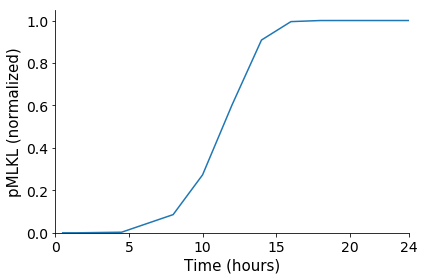

In [19]:
fig, ax = plt.subplots()
# for n in range(len(mode1_100)):
plt.plot(tspan/60, mode1df_wtm1.loc[:]['MLKLa_obs'].iloc[:]/5544, lw=1.5, 
             zorder = 1)
# colormap = plt.cm.Reds #nipy_spectral, Set1,Paired   
# colors = [colormap(i) for i in np.linspace(0, 1,len(ax.lines))]
# for i,j in enumerate(ax.lines):
#     j.set_color(colors[i])
# ax1.legend(loc=2)    
plt.xlabel("Time (hours)", fontsize=15)
plt.ylabel("pMLKL (normalized)", fontsize=15)
plt.xlim(xmin = 0, xmax = 16)
plt.ylim(ymin = 0)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
right_side = ax.spines["right"]
right_side.set_visible(False)
top = ax.spines["top"]
top.set_visible(False)
ax.set_xticks([0, 5, 10, 15, 20, 24])
ax.grid(False)
plt.tight_layout()
# plt.savefig('pmlkl_allpars_clus0_tnf100_noframe.pdf')
plt.show() 

In [ ]:
model.parameters

In [20]:
with open('necro_5720mode4_paramk6_mod_tnf100.txt', 'w') as f:
   for p, v in zip(model.parameters, mode1wtm1.param_values[0]):
       f.write('{},{:e}\n'.format(p.name, v))

In [21]:
def update_param_vals(model, newvals):
    """update the values of model parameters with the values from a dict.
    the keys in the dict must match the parameter names
    """
    update = []
    noupdate = []
    for i in model.parameters:
        if i.name in newvals:
            i.value = newvals[i.name]
            update.append(i.name)
        else:
            noupdate.append(i.name)
    return update, noupdate

In [ ]:
def process():
    all_df = []
    n = 1
    sens.p_matrix = np.loadtxt(
        os.path.join(out_dir, 'output_{}_p_matrix.csv'))
    sens.p_prime_matrix = np.loadtxt(
        os.path.join(out_dir, 'output_{}_p_prime_matrix.csv'))
    x = [np.array(mat).flatten() for mat in
         sens.sensitivity_multiset]
    df = pd.DataFrame(
        [{'name': i, 'values': v} for i, j in
         zip(sens.index, x) for v in j])
    # df = pd.DataFrame(df, columns=sens.index)
    df['parameter_set'] = n
    all_df.append(df)

    all_df = pd.concat(all_df)
    all_df.to_csv("mode4_initials_k6/sens_summary.csv")

In [22]:
setup_logger(logging.INFO, file_output='necroclusters2large_5720.log', console_output=True)
observable = 'MLKLa_obs'

tspan = np.array([30, 90, 270, 480, 600, 720, 840, 960, 1080, 1200, 1320, 1440])

def likelihood(mlkl_traj):
    #Here we fit a spline to find where we get 50% release of MOMP reporter
    ysim_mlkl_norm = mlkl_traj / np.nanmax(mlkl_traj)
    st, sc, sk = scipy.interpolate.splrep(tspan, ysim_mlkl_norm)
    try:
        t10 = scipy.interpolate.sproot((st, sc - 0.10, sk))[0]
        t90 = scipy.interpolate.sproot((st, sc - 0.90, sk))[0]
    except IndexError:
        t10 = 0
        t90 = 0

    # time of death  = halfway point between 10 and 90%
    td = (t10 + t90) / 2

    return td

def run():
    vals = np.linspace(0.7, 1.3, 5)
    new_params2 = pd.read_csv('necro_5720mode4_paramk6_mod_tnf100.txt',
        index_col=0, names=['name', 'value']).to_dict('dict')['value']

    update_param_vals(model, new_params2)

    use_cupsoda = False
    if use_cupsoda:
        integrator_opt = {'rtol': 1e-6, 'atol': 1e-6, 'max_steps': 20000,
                          'memory_usage': 'global', 'vol': 1e-19}
        solver = CupSodaSimulator(model, t, verbose=True, gpu=0,
                                  integrator_options=integrator_opt,
                                  )
    else:
        integrator_opt_scipy = {'rtol': 1e-6, 'atol': 1e-6, 'mxstep': 20000}
        solver = ScipyOdeSimulator(model, tspan=tspan, integrator='lsoda',
                                   integrator_options=integrator_opt_scipy)
    sens = InitialsSensitivity(
        solver,
        values_to_sample=vals,
        observable=observable,
        objective_function=likelihood, sens_type='initials')  #

    sens.run('output_{}', out_dir=out_dir)
    sens.create_heatplot(save_name='mode4k6heatinew', out_dir=out_dir)
    sens.create_boxplot(save_name='mode4k6boxinew', out_dir=out_dir)

if __name__ == '__main__':
    model_v = 'necro'
    # all parameter fits from pso
#     p_set = 'all_params_24_part_200_iter_2_bound_0.1_speed.csv'
    params = pd.read_csv('necro_5720mode4_paramk6_mod_tnf100.txt',
        index_col=0, names=['name', 'value']).to_dict('dict')['value']
#     print(len(params))
    # how many sens analysis to run
    n_sets = 1

    # spacing for sens analysis
    vals = np.linspace(.7, 1.3, 5)

    solver = ScipyOdeSimulator(model, tspan, integrator='lsoda',
                               verbose=True,
                               use_analytic_jacobian=True,
                               compiler='cython',
                               integrator_options={"rtol": 1e-6,
                                                   "atol": 1e-6})
    # The observable of the model
    observable = 'MLKLa_obs'
    sens = InitialsSensitivity(
        values_to_sample=vals,
        observable=observable,
        objective_function=likelihood,
        solver=solver,sens_type = 'initials'
    )
    out_dir = 'mode4_initials_k6_mid'
#     out_dir = p_set.split(',')[0]
#     if not os.path.exists(out_dir):
#         os.mkdir(out_dir)
    run()
#     process()
#     load()

2021-12-31 16:18:11.238 - pysb - INFO - Logging started on PySB version 1.11.0
2021-12-31 16:18:11.239 - pysb - INFO - Log entry time offset from UTC: -6.00 hours
2021-12-31 16:18:11.253 - pysb.simulator.scipyode - DEBUG - [model_files.nerm_pvals] Simulator created
2021-12-31 16:18:11.947 - pysb.simulator.scipyode - DEBUG - [model_files.nerm_pvals] Simulator created
2021-12-31 16:18:11.951 - pysb.simulator.scipyode - DEBUG - [model_files.nerm_pvals] Equation mode set to "cython"


2021-12-31 16:18:12.632 - pysb.simulator.scipyode - INFO - [model_files.nerm_pvals] Simulation(s) started
2021-12-31 16:18:12.675 - pysb.simulator.scipyode - DEBUG - [model_files.nerm_pvals] Single processor (serial) mode
2021-12-31 16:18:12.740 - pysb.simulator.scipyode - INFO - [model_files.nerm_pvals] All simulation(s) complete
2021-12-31 16:18:12.741 - pysb.simulator.scipyode - DEBUG - [model_files.nerm_pvals] SimulationResult constructor started
2021-12-31 16:18:12.776 - pysb.simulator.scipyode - DEBUG - [model_files.nerm_pvals] SimulationResult constructor finished
2021-12-31 16:18:12.777 - pysb.simulator.scipyode - INFO - [model_files.nerm_pvals] Simulation(s) started


2021-12-31 16:18:12.921 - pysb.simulator.scipyode - DEBUG - [model_files.nerm_pvals] Multi-processor (parallel) mode using 20 processes
2021-12-31 16:20:09.116 - pysb.simulator.scipyode - INFO - [model_files.nerm_pvals] All simulation(s) complete
2021-12-31 16:20:09.118 - pysb.simulator.scipyode - DEBUG - [model_files.nerm_pvals] SimulationResult constructor started
2021-12-31 16:20:09.957 - pysb.simulator.scipyode - DEBUG - [model_files.nerm_pvals] SimulationResult constructor finished


14.057337024733151
-14.057337024733151
0.06910831989702775
-0.0511894749549547


In [4]:
setup_logger(logging.INFO, file_output='necroclusters2large_5720.log', console_output=True)
observable = 'MLKLa_obs'

tspan = np.array([30, 90, 270, 480, 600, 720, 840, 960, 1080, 1200, 1320, 1440])

def likelihood(mlkl_traj):
    #Here we fit a spline to find where we get 50% release of MOMP reporter
    ysim_mlkl_norm = mlkl_traj / np.nanmax(mlkl_traj)
    st, sc, sk = scipy.interpolate.splrep(tspan, ysim_mlkl_norm)
    try:
        t10 = scipy.interpolate.sproot((st, sc - 0.10, sk))[0]
        t90 = scipy.interpolate.sproot((st, sc - 0.90, sk))[0]
    except IndexError:
        t10 = 0
        t90 = 0

    # time of death  = halfway point between 10 and 90%
    td = (t10 + t90) / 2

    return td

def run():
    vals = np.linspace(0.7, 1.3, 5)
    new_params2 = pd.read_csv('necro_5720mode4_paramk5tnf100.txt',
        index_col=0, names=['name', 'value']).to_dict('dict')['value']

    update_param_vals(model, new_params2)

    use_cupsoda = False
    if use_cupsoda:
        integrator_opt = {'rtol': 1e-6, 'atol': 1e-6, 'max_steps': 20000,
                          'memory_usage': 'global', 'vol': 1e-19}
        solver = CupSodaSimulator(model, t, verbose=True, gpu=0,
                                  integrator_options=integrator_opt,
                                  )
    else:
        integrator_opt_scipy = {'rtol': 1e-6, 'atol': 1e-6, 'mxstep': 20000}
        solver = ScipyOdeSimulator(model, tspan=tspan, integrator='lsoda',
                                   integrator_options=integrator_opt_scipy)
    sens = InitialsSensitivity(
        solver,
        values_to_sample=vals,
        observable=observable,
        objective_function=likelihood, sens_type='initials')  #

    sens.run('output_{}', out_dir=out_dir)
    sens.create_heatplot(save_name='mode4k5heatinew', out_dir=out_dir)
    sens.create_boxplot(save_name='mode4k5boxinew', out_dir=out_dir)

if __name__ == '__main__':
    model_v = 'necro'
    # all parameter fits from pso
#     p_set = 'all_params_24_part_200_iter_2_bound_0.1_speed.csv'
    params = pd.read_csv('necro_5720mode4_paramk5tnf100.txt',
        index_col=0, names=['name', 'value']).to_dict('dict')['value']
#     print(len(params))
    # how many sens analysis to run
    n_sets = 1

    # spacing for sens analysis
    vals = np.linspace(.7, 1.3, 5)

    solver = ScipyOdeSimulator(model, tspan, integrator='lsoda',
                               verbose=True,
                               use_analytic_jacobian=True,
                               compiler='cython',
                               integrator_options={"rtol": 1e-6,
                                                   "atol": 1e-6})
    # The observable of the model
    observable = 'MLKLa_obs'
    sens = InitialsSensitivity(
        values_to_sample=vals,
        observable=observable,
        objective_function=likelihood,
        solver=solver,sens_type = 'initials'
    )
    out_dir = 'mode4_initials_k5'
#     out_dir = p_set.split(',')[0]
#     if not os.path.exists(out_dir):
#         os.mkdir(out_dir)
    run()
#     process()
#     load()

2021-12-31 16:02:38.266 - pysb - INFO - Logging started on PySB version 1.11.0
2021-12-31 16:02:38.267 - pysb - INFO - Log entry time offset from UTC: -6.00 hours
2021-12-31 16:02:38.280 - pysb.simulator.scipyode - DEBUG - [model_files.nerm_pvals] Simulator created
2021-12-31 16:02:38.971 - pysb.simulator.scipyode - DEBUG - [model_files.nerm_pvals] Simulator created
2021-12-31 16:02:38.975 - pysb.simulator.scipyode - DEBUG - [model_files.nerm_pvals] Equation mode set to "cython"


2021-12-31 16:02:39.481 - pysb.simulator.scipyode - INFO - [model_files.nerm_pvals] Simulation(s) started
2021-12-31 16:02:39.524 - pysb.simulator.scipyode - DEBUG - [model_files.nerm_pvals] Single processor (serial) mode
2021-12-31 16:02:39.603 - pysb.simulator.scipyode - INFO - [model_files.nerm_pvals] All simulation(s) complete
2021-12-31 16:02:39.604 - pysb.simulator.scipyode - DEBUG - [model_files.nerm_pvals] SimulationResult constructor started
2021-12-31 16:02:39.640 - pysb.simulator.scipyode - DEBUG - [model_files.nerm_pvals] SimulationResult constructor finished
2021-12-31 16:02:39.641 - pysb.simulator.scipyode - INFO - [model_files.nerm_pvals] Simulation(s) started


2021-12-31 16:02:39.783 - pysb.simulator.scipyode - DEBUG - [model_files.nerm_pvals] Multi-processor (parallel) mode using 20 processes
2021-12-31 16:04:38.509 - pysb.simulator.scipyode - INFO - [model_files.nerm_pvals] All simulation(s) complete
2021-12-31 16:04:38.511 - pysb.simulator.scipyode - DEBUG - [model_files.nerm_pvals] SimulationResult constructor started
2021-12-31 16:04:39.367 - pysb.simulator.scipyode - DEBUG - [model_files.nerm_pvals] SimulationResult constructor finished


12.618919198526449
-12.618919198526449
4.292047888208389e-05
-4.25783344749488e-05


In [6]:
setup_logger(logging.INFO, file_output='necroclusters2large_5720.log', console_output=True)
observable = 'MLKLa_obs'

tspan = np.array([30, 90, 270, 480, 600, 720, 840, 960, 1080, 1200, 1320, 1440])

def likelihood(mlkl_traj):
    #Here we fit a spline to find where we get 50% release of MOMP reporter
    ysim_mlkl_norm = mlkl_traj / np.nanmax(mlkl_traj)
    st, sc, sk = scipy.interpolate.splrep(tspan, ysim_mlkl_norm)
    try:
        t10 = scipy.interpolate.sproot((st, sc - 0.10, sk))[0]
        t90 = scipy.interpolate.sproot((st, sc - 0.90, sk))[0]
    except IndexError:
        t10 = 0
        t90 = 0

    # time of death  = halfway point between 10 and 90%
    td = (t10 + t90) / 2

    return td

def run():
    vals = np.linspace(0.7, 1.3, 5)
    new_params2 = pd.read_csv('necro_5720mode4_paramk7tnf100.txt',
        index_col=0, names=['name', 'value']).to_dict('dict')['value']

    update_param_vals(model, new_params2)

    use_cupsoda = False
    if use_cupsoda:
        integrator_opt = {'rtol': 1e-6, 'atol': 1e-6, 'max_steps': 20000,
                          'memory_usage': 'global', 'vol': 1e-19}
        solver = CupSodaSimulator(model, t, verbose=True, gpu=0,
                                  integrator_options=integrator_opt,
                                  )
    else:
        integrator_opt_scipy = {'rtol': 1e-6, 'atol': 1e-6, 'mxstep': 20000}
        solver = ScipyOdeSimulator(model, tspan=tspan, integrator='lsoda',
                                   integrator_options=integrator_opt_scipy)
    sens = InitialsSensitivity(
        solver,
        values_to_sample=vals,
        observable=observable,
        objective_function=likelihood, sens_type='initials')  #

    sens.run('output_{}', out_dir=out_dir)
    sens.create_heatplot(save_name='mode4k7heatinew', out_dir=out_dir)
    sens.create_boxplot(save_name='mode4k7boxinew', out_dir=out_dir)

if __name__ == '__main__':
    model_v = 'necro'
    # all parameter fits from pso
#     p_set = 'all_params_24_part_200_iter_2_bound_0.1_speed.csv'
    params = pd.read_csv('necro_5720mode4_paramk7tnf100.txt',
        index_col=0, names=['name', 'value']).to_dict('dict')['value']
#     print(len(params))
    # how many sens analysis to run
    n_sets = 1

    # spacing for sens analysis
    vals = np.linspace(.7, 1.3, 5)

    solver = ScipyOdeSimulator(model, tspan, integrator='lsoda',
                               verbose=True,
                               use_analytic_jacobian=True,
                               compiler='cython',
                               integrator_options={"rtol": 1e-6,
                                                   "atol": 1e-6})
    # The observable of the model
    observable = 'MLKLa_obs'
    sens = InitialsSensitivity(
        values_to_sample=vals,
        observable=observable,
        objective_function=likelihood,
        solver=solver,sens_type = 'initials'
    )
    out_dir = 'mode4_initials_k7'
#     out_dir = p_set.split(',')[0]
#     if not os.path.exists(out_dir):
#         os.mkdir(out_dir)
    run()
#     process()
#     load()

2021-12-31 16:05:09.027 - pysb - INFO - Logging started on PySB version 1.11.0
2021-12-31 16:05:09.028 - pysb - INFO - Log entry time offset from UTC: -6.00 hours
2021-12-31 16:05:09.041 - pysb.simulator.scipyode - DEBUG - [model_files.nerm_pvals] Simulator created
2021-12-31 16:05:09.730 - pysb.simulator.scipyode - DEBUG - [model_files.nerm_pvals] Simulator created
2021-12-31 16:05:09.734 - pysb.simulator.scipyode - DEBUG - [model_files.nerm_pvals] Equation mode set to "cython"


2021-12-31 16:05:10.327 - pysb.simulator.scipyode - INFO - [model_files.nerm_pvals] Simulation(s) started
2021-12-31 16:05:10.371 - pysb.simulator.scipyode - DEBUG - [model_files.nerm_pvals] Single processor (serial) mode
2021-12-31 16:05:10.446 - pysb.simulator.scipyode - INFO - [model_files.nerm_pvals] All simulation(s) complete
2021-12-31 16:05:10.447 - pysb.simulator.scipyode - DEBUG - [model_files.nerm_pvals] SimulationResult constructor started
2021-12-31 16:05:10.482 - pysb.simulator.scipyode - DEBUG - [model_files.nerm_pvals] SimulationResult constructor finished
2021-12-31 16:05:10.483 - pysb.simulator.scipyode - INFO - [model_files.nerm_pvals] Simulation(s) started


2021-12-31 16:05:10.627 - pysb.simulator.scipyode - DEBUG - [model_files.nerm_pvals] Multi-processor (parallel) mode using 20 processes
2021-12-31 16:07:03.670 - pysb.simulator.scipyode - INFO - [model_files.nerm_pvals] All simulation(s) complete
2021-12-31 16:07:03.673 - pysb.simulator.scipyode - DEBUG - [model_files.nerm_pvals] SimulationResult constructor started
2021-12-31 16:07:04.517 - pysb.simulator.scipyode - DEBUG - [model_files.nerm_pvals] SimulationResult constructor finished


12.88857342160618
-12.88857342160618
5.9652092867505675e-05
-6.145918837590981e-05
